In [1]:
library(ape)
library(jsonlite)
library(pheatmap)
library(reshape2)
library(ggplot2)
library(RColorBrewer)
library(viridis)
suppressPackageStartupMessages(library(ggtree))
suppressPackageStartupMessages(library(Biostrings))

dataDir <- "Data"
genomeTreeDir <- "Genome_tree"
snpDir <- "SNPs"
figureDir <- "Figures"

Warning message:
"package 'jsonlite' was built under R version 3.6.2"
Warning message:
"package 'pheatmap' was built under R version 3.6.2"
Warning message:
"package 'reshape2' was built under R version 3.6.2"
Loading required package: viridisLite

Warning message:
"package 'S4Vectors' was built under R version 3.6.2"
Warning message:
"package 'IRanges' was built under R version 3.6.2"


In [2]:
dir.create(figureDir, showWarnings = FALSE)

In [3]:
tree <- read.tree(file.path(genomeTreeDir, "RAxML_bestTree.GTRGAMMA"))
info <- read.csv(file.path(dataDir, "info.csv"))
allSNP <- read.csv(file.path(snpDir, "all.csv"))
genotypes <- read_json(file.path(dataDir, "genotypes.json"))

In [4]:
info <- info[complete.cases(info), ]

root2tipDist <- data.frame(
    "Dist" = node.depth.edgelength(tree)[1:length(tree$tip.label)],
    "Accession.ID" = tree$tip.label
)

info <- merge(info, root2tipDist, by = "Accession.ID")

In [5]:
info[["Genotype"]] <- NULL

for (gp in names(genotypes)) {
    for (id in genotypes[[gp]]) {
        info[which(info$Accession.ID == id), "Genotype"] <- gp
    }
}

Saving 6.67 x 6.67 in image



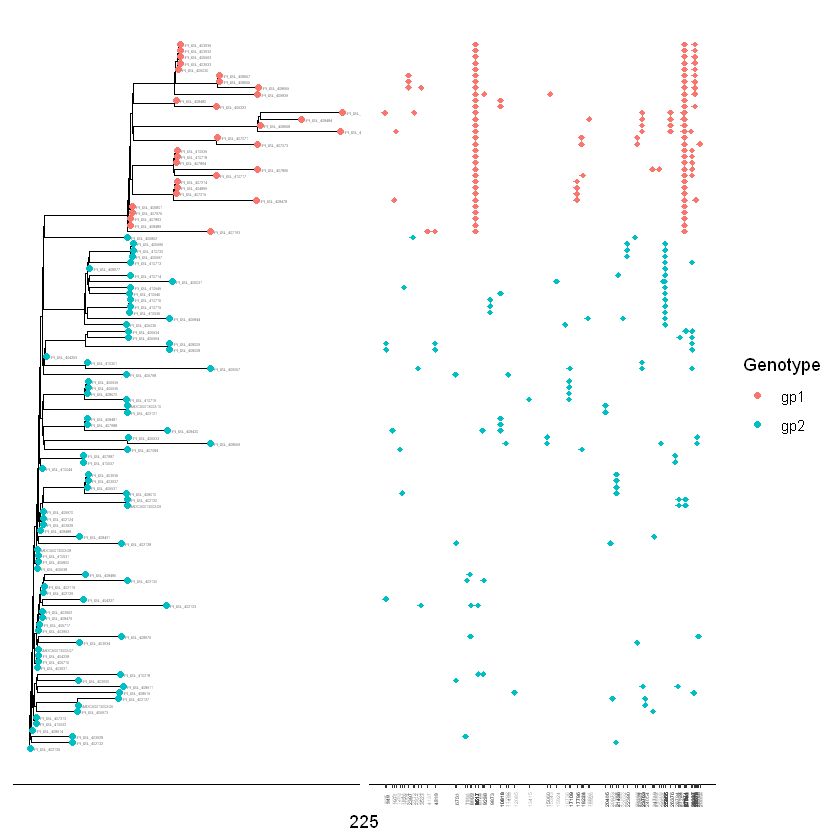

In [6]:
p <- ggtree(tree)
p <- p %<+% info + 
    geom_tiplab(size = 0.75) + 
    geom_tippoint(aes(color=Genotype)) +
    theme(legend.position = "right")
# p
snp_data <- allSNP[, c("Accession.ID", "Pos")]
p <- p + geom_facet(
    panel = "SNP",
    data = snp_data,
    geom = geom_point,
    mapping=aes(x = Pos, color=Genotype),
    shape = 18
) + 
# theme(
# ) +
theme_tree2(
    strip.background = element_blank(),
    strip.text.x = element_blank(),
    axis.text.x = element_text(angle = 90, vjust = 0.5, size = 3)
) +
scale_x_continuous(snp_data$Pos, labels = snp_data$Pos, breaks = snp_data$Pos)
print(p)

ggsave(filename = file.path(figureDir, "figure2.png"), plot = p)

Saving 6.67 x 6.67 in image



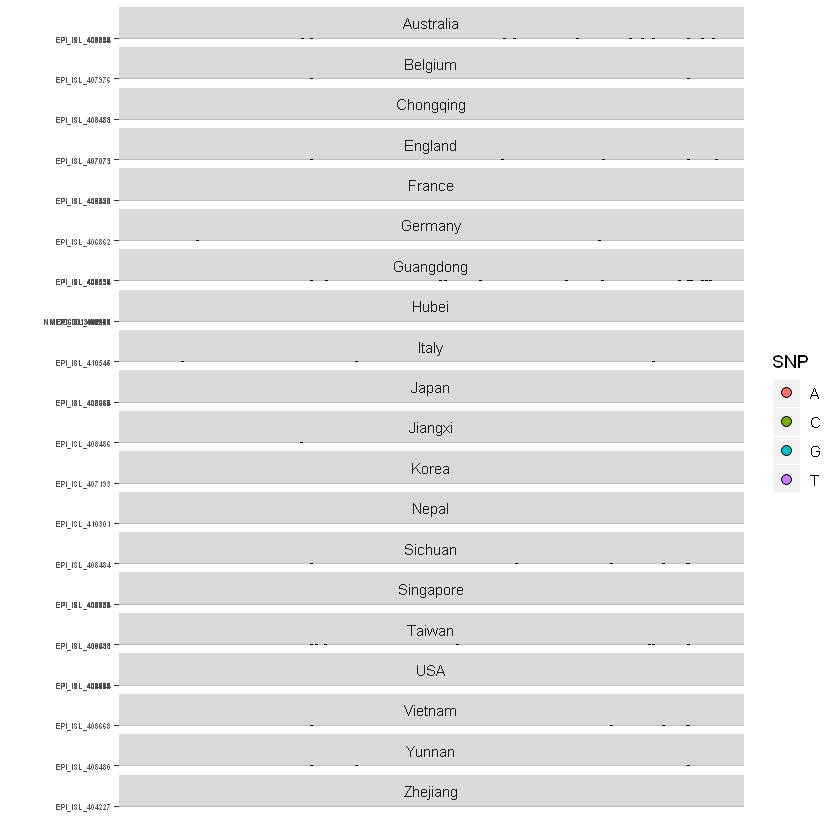

In [7]:
snp <- allSNP[, c("Accession.ID", "Pos", "SNP", "Product")]
snp <- merge(snp, info, by = "Accession.ID", all.x = TRUE)
snp["isHubei"] <- factor(c("non-Hubei", "Hubei")[(as.character(snp$Area) == "Hubei") + 1])
# levels(snp$Accession.ID) <- as.character(snp$Accession.ID[order(snp$Area)])
snp$Area_ID <- as.integer(snp$Area)

p <- ggplot(snp, aes(x = reorder(Accession.ID, Area_ID), y = Pos, fill = SNP)) +
    geom_dotplot(binaxis = "y", binwidth = 1, dotsize = 250) +
#     xlim(seq_len(0, 21399)) +
    coord_flip() +
    ylab("") + xlab("") +
    facet_wrap( ~ Area, nrow = length(unique(snp$Area)), scales = "free_y") +
    theme(panel.grid.major = element_line(colour="grey", size = 0.1), 
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank(),
          panel.background = element_rect(fill = NA),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank(),
          axis.text.y=element_text(size=5, face="bold"))
print(p)

ggsave(filename = file.path(figureDir, "figure4.png"), plot = p)

In [8]:
forlabeling <- unique(snp[, c("Accession.ID", "Area", "Genotype")])
forlabeling <- lapply(split(forlabeling, forlabeling$Genotype), function(i) {
    res <- i[order(i[["Area"]]), ]
    res
})
# forlabeling

# for (gp in names(forlabeling)) {
#     write.csv(forlabeling[[gp]], file.path(snpDir, paste0(gp, "SNParea.csv")))
# }

In [9]:
seqs <- readDNAMultipleAlignment(file.path(genomeTreeDir, "aligned_cds.fasta"))
seqs <- as.character(seqs)

aaMut <- as.data.frame(t(apply(allSNP, 1, function(row) {
    accession <- row[["Accession.ID"]]
    pos <- as.integer(row[["Pos"]])
    shift <- pos %% 3
    if (shift == 0) {
        codon <- substr(seqs[[accession]], pos - 2, pos)
        refCodon <- paste0(substr(codon, 1, 2), row[["Ref"]])
    } else if (shift == 1) {
        codon <- substr(seqs[[accession]], pos, pos + 2)
        refCodon <- paste0(row[["Ref"]], substr(codon, 2, 3))
    } else {
        codon <- substr(seqs[[accession]], pos - 1, pos + 1)
        refCodon <- paste0(substr(codon, 1, 1), row[["Ref"]], substr(codon, 3, 3))
    }
    
    aa <- GENETIC_CODE[[codon]]
    refAA <- GENETIC_CODE[[refCodon]]
    
    aaPos <- ceiling(pos / 3)
    
    c(row[["Accession.ID"]], aa, refAA, codon, refCodon, aaPos, row[["Product"]])
})), stringsAsFactors = FALSE)

colnames(aaMut) <- c("Accession.ID", "mutAA", "refAA", "codon", "refCodon", "aaPos", "Product")
write.csv(aaMut, file.path(snpDir, "amino_acid.csv"), row.names = FALSE)

In [10]:
aaMut <- aaMut[which(aaMut$mutAA != aaMut$refAA), c("Accession.ID", "mutAA", "refAA", "aaPos", "Product")]

In [11]:
aaSubNames <- dcast(aaMut[, c("Accession.ID", "aaPos", "refAA")], Accession.ID ~ aaPos, value.var = "refAA")
aaSubNames[is.na(aaSubNames)] <- ""
row.names(aaSubNames) <- aaSubNames$Accession.ID
aaSubNames <- aaSubNames[, -1]
aaSubNames <- aaSubNames[, order(as.integer(colnames(aaSubNames)))]

ancAAnames <- data.frame(t(unique(aaMut[, c("aaPos", "refAA")])[["refAA"]]))
colnames(ancAAnames) <- colnames(aaSubNames)
rownames(ancAAnames) <- "Ancestral"

aaSubMatNames <- rbind(ancAAnames, aaSubNames)

# for (i in seq_len(ncol(aaSubMatNames))) {
#     aaSubMatNames[is.na(aaSubMatNames[, i]), i] <- aaSubMatNames["Ancestral", i]
# }

In [12]:
aaSub <- aaMut
aaSub <- merge(aaSub, info, by = "Accession.ID", all.x = TRUE)

aaSub[["Mutated"]] <- 1
# as.integer(as.factor(aaSub[["Genotype"]]))

aaSub <- dcast(aaSub[, c("Accession.ID", "aaPos", "Mutated")], Accession.ID ~ aaPos, value.var = "Mutated")
aaSub[is.na(aaSub)] <- 0
row.names(aaSub) <- aaSub$Accession.ID
aaSub <- aaSub[, -1]
aaSub <- aaSub[, order(as.integer(colnames(aaSub)))]

ancAA <- data.frame(t(rep(2, ncol(aaSub))))
colnames(ancAA) <- colnames(aaSub)
rownames(ancAA) <- "Ancestral"

aaSubMat <- rbind(ancAA, aaSub)

In [13]:
productID <- as.data.frame(unique(aaMut[,c("aaPos", "Product")]))
productID$Product <- as.integer(as.factor(productID$Product))
productID <- data.frame(productID[order(productID$aaPos), ])
rn <- productID$aaPos
productID <- data.frame(productID$Product)
row.names(productID) <- rn
colnames(productID) <- "Domain"
productColors <- list("Domain" = brewer.pal(8, "Set1"))

In [14]:
strainAnno <- info[, c("Accession.ID", "Genotype", "Area")]
strainsLoc <- as.data.frame(unique(strainAnno[, c("Accession.ID", "Genotype", "Area")]))
row.names(strainsLoc) <- strainsLoc[["Accession.ID"]]
strainsLoc <- strainsLoc[, -1]

png 
  2

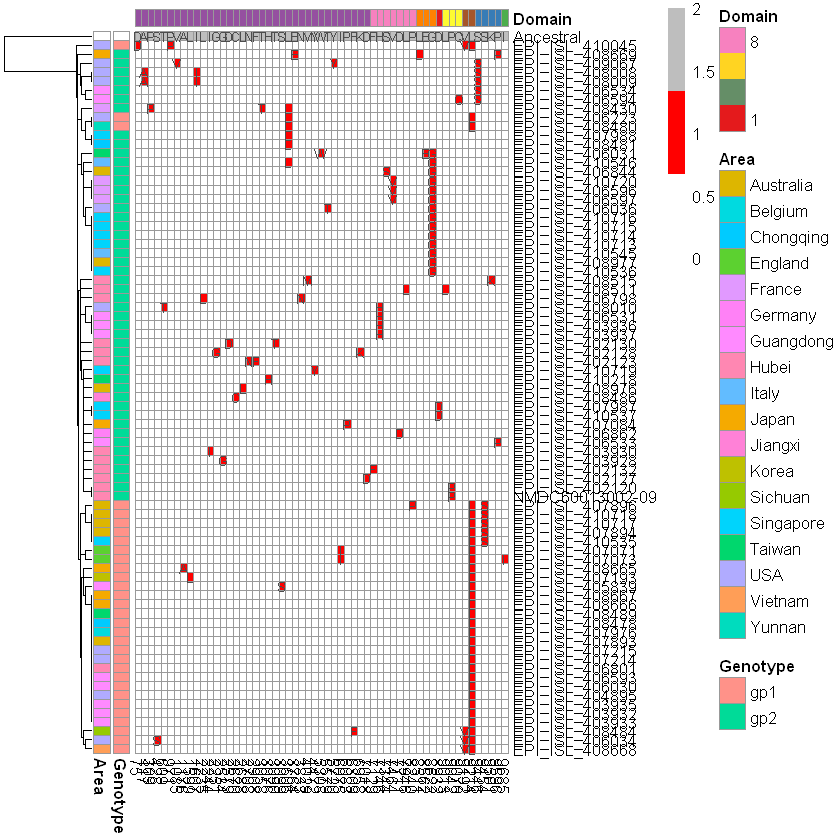

In [15]:
p <- pheatmap(
    mat               = aaSubMat,
    color = colorRampPalette(c("white", "red", "grey"))(3),
#     border_color      = NA,
    show_colnames     = TRUE,
    show_rownames     = TRUE,
    cluster_cols = FALSE,
#     cluster_rows = FALSE,
    annotation_col    = productID,
    annotation_colors = productColors,
    annotation_row = strainsLoc,
    drop_levels       = TRUE,
    display_numbers = aaSubMatNames,
#     annotation_legend = FALSE
)
png(filename = file.path(figureDir, "figure3.png"), width=800, height=800)
grid::grid.newpage()
grid::grid.draw(p$gtable)
dev.off()